# Первая модель

# Зайцев Н. ПИ20-1В

Подключение Google-Drive

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## Настройка загрузчиков данных

Мы будем использовать встроенный набор данных `torchvision.datasets.ImageFolder` для быстрой настройки некоторых загрузчиков данных загруженных изображений кошек и рыб.

`check_image` - это быстрая маленькая функция, которая передается параметру `is_valid_file` в ImageFolder и выполняет проверку, чтобы убедиться, что PIL действительно может открыть файл. Мы собираемся использовать это вместо очистки загруженного набора данных.

In [162]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

Настроим преобразование для каждого фото:

* Изменим размер на 64x64
* Преобразуем в тензор
* Нормализуем используя ImageNet mean и std
* Преобразуем метку в тензор


In [163]:
import numpy as np

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
def lab_trans(lab):
  y = np.where(lab=='fish', 1, 0)
  return torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(y).long(), value=1)

lab_trans('fish')



tensor([0., 1.])

In [164]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

#import natsort

class CatFishDataSet(Dataset):
    def __init__(self, main_dir, transform, label_transform, check):
        self.main_dir = main_dir
        self.transform = transform
        self.label_transform = label_transform
        self.check=check
        self.labels = os.listdir(main_dir)
        self.img_list=[]
        for label in self.labels:
          label_path = os.path.join(self.main_dir, label)
          imglist=[(label, os.path.join(label_path,i)) for i in os.listdir(label_path) if self.check(os.path.join(label_path,i))]
          self.img_list+=imglist
           
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        lab, img_loc = self.img_list[idx]
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        tensor_image=tensor_image.view(1,-1)
        label = self.label_transform(lab)
        return tensor_image, label

train_data_path = "train/"
train_data = CatFishDataSet(train_data_path, transform=img_transforms, label_transform=lab_trans, check=check_image)
img_list=train_data.img_list


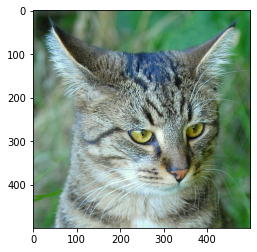

In [165]:
img=Image.open(train_data.img_list[3][1])
plt.imshow(img)


In [166]:
train_data.__getitem__(1)[0].shape

torch.Size([1, 12288])

In [167]:
os.getcwd()

'c:\\Users\\Fomichev Nikita\\Desktop\\Study\\ТАДиМО\\ML_course_2\\Lection_2'

In [168]:
val_data_path = "val/"
val_data = CatFishDataSet(val_data_path, transform=img_transforms, label_transform=lab_trans, check=check_image)


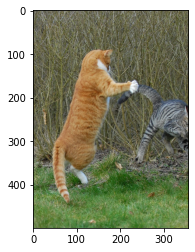

In [169]:
img=Image.open(val_data.img_list[3][1])
plt.imshow(img)

In [170]:
val_data.__getitem__(1)[0].shape

torch.Size([1, 12288])

In [171]:
test_data_path = "test/"
test_data = CatFishDataSet(test_data_path, transform=img_transforms, label_transform=lab_trans, check=check_image) 

In [172]:
test_data.__getitem__(1)[0].shape

torch.Size([1, 12288])

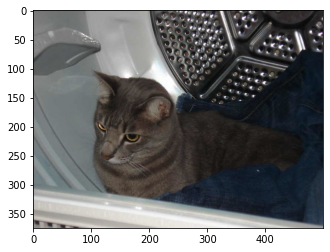

In [173]:
img=Image.open(test_data.img_list[3][1])
plt.imshow(img)

In [174]:
batch_size=64

In [175]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

## Первая модель SimpleNet

SimpleNet-это очень простая комбинация трех линейных слоев и функцией активации ReLu между ними. Обратите внимание, что поскольку мы не используем функцию активации softmax() в функции forward(), нам нужно будет убедиться, что мы используем ее в нашей обучающей функции на этапе проверки.

In [176]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [177]:
simplenet = SimpleNet()

## Оптимизация

Возпользуемся оптимизацией Adam с темпом обучения 0.001

In [178]:
import torch.optim as optim
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

## Перенос модели на GPU


In [179]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)
device

device(type='cuda')

## Обучение

Обучает модель, при необходимости копируя пакеты на графический процессор, вычисляя потери, оптимизируя сеть и выполняя валидацию для каждой эпохи.

In [180]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cuda'):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], torch.max(targets, dim=1)[1]).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [181]:
for batch in val_data_loader:
            inputs, targets = batch
            inputs=inputs.to(device)
            inputs.device
            print(inputs.shape)

torch.Size([64, 1, 12288])
torch.Size([40, 1, 12288])


In [182]:
output = simplenet(inputs)
torch.max(F.softmax(output),dim=1)[1]

<ipython-input-182-0ec0591acb56>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.max(F.softmax(output),dim=1)[1]


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [183]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)

<ipython-input-180-3e00916fa184>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], torch.max(targets, dim=1)[1]).view(-1)


Epoch: 0, Training Loss: 2.62, Validation Loss: 4.84, accuracy = 0.31
Epoch: 1, Training Loss: 2.45, Validation Loss: 1.39, accuracy = 0.69
Epoch: 2, Training Loss: 0.95, Validation Loss: 0.83, accuracy = 0.53
Epoch: 3, Training Loss: 0.75, Validation Loss: 0.70, accuracy = 0.69
Epoch: 4, Training Loss: 0.54, Validation Loss: 0.64, accuracy = 0.69


In [184]:
output

tensor([[ 0.0233,  0.1250],
        [-0.1013,  0.0565],
        [-0.0370,  0.0602],
        [ 0.0245,  0.2148],
        [ 0.0382,  0.1154],
        [-0.0528,  0.0459],
        [-0.0527,  0.2076],
        [-0.0112,  0.1279],
        [-0.0429,  0.0575],
        [ 0.0347,  0.1201],
        [ 0.0327,  0.0553],
        [-0.0123,  0.0641],
        [-0.1387,  0.1218],
        [ 0.1203,  0.0580],
        [-0.0621,  0.1062],
        [-0.0929,  0.2191],
        [-0.0754,  0.0620],
        [-0.0741,  0.0510],
        [-0.1318,  0.1355],
        [-0.0483,  0.0740],
        [ 0.0955,  0.0930],
        [-0.0651,  0.0045],
        [-0.0750,  0.1184],
        [-0.0382,  0.1230],
        [-0.1729,  0.1031],
        [-0.0379,  0.0509],
        [-0.1404,  0.1350],
        [-0.0395,  0.1023],
        [-0.0837,  0.0788],
        [ 0.0213,  0.0475],
        [ 0.1270,  0.0609],
        [-0.1008,  0.1548],
        [-0.0520,  0.0474],
        [-0.0366,  0.1436],
        [-0.1882,  0.1897],
        [-0.1071,  0

## Предсказания

Метки расположены в алфавитно-цифровом порядке, поэтому `cat` будет равен 0, `fish` - 1. Нам нужно будет преобразовать изображение, а также убедиться, что полученный тензор скопирован на соответствующее устройство, прежде чем применять к нему нашу модель.

In [185]:
labels = ['cat','fish']

img = Image.open("test/cat/2229414874_ed4524d3dd.jpg")

img = img_transforms(img)
img = img.unsqueeze(0)
img = img.to(device)


prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

cat


## Сохранение модели

Мы можем либо сохранить всю модель через `save` или просто параметры, используя `state_dict`. Использование последнего обычно предпочтительнее, поскольку оно позволяет повторно использовать параметры, даже если структура модели изменяется (или применять параметры из одной модели в другую).

In [186]:
torch.save(simplenet, "simplenet") 
simplenet = torch.load("simplenet")    


In [187]:
torch.save(simplenet.state_dict(), "simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("simplenet")
simplenet.load_state_dict(simplenet_state_dict)   

<All keys matched successfully>

Наборы данных и загрузчики данных
---
Код для обработки образцов данных может быть запутанным и сложным в обслуживании; в идеале мы хотим, чтобы наш код набора данных был отделен от кода обучения модели для лучшей читаемости и модульности. PyTorch предоставляет два примитива данных: `torch.utils.data.DataLoader` и `torch.utils.data.Dataset`. Набор данных, позволяющий использовать предварительно загруженные наборы данных, а также ваши собственные данные. Набор данных хранит образцы и соответствующие им метки, а загрузчик данных оборачивает итерацию вокруг набора данных, чтобы обеспечить легкий доступ к образцам.

Библиотеки домена PyTorch предоставляют ряд предварительно загруженных наборов данных (таких как FashionMNIST), которые относятся к подклассу `torch.utils.data.Dataset` и реализация функций, специфичных для конкретных данных. Они могут быть использованы для создания прототипа и тестирования вашей модели. Вы можете найти их здесь: [Наборы данных изображений](#https://pytorch.org/vision/stable/datasets.html), [Текстовые наборы данных](#https://pytorch.org/text/stable/datasets.html) и [Наборы аудиоданных](#https://pytorch.org/audio/stable/datasets.html).

Загрузка набора данных
---
Вот пример того, как загрузить набор данных Fashion-MNIST из Torch Vision. Fashion-MNIST -- это набор данных изображений статей Заландо, состоящий из 60 000 обучающих примеров и 10 000 тестовых примеров. Каждый пример содержит изображение в оттенках серого 28×28 и соответствующую метку из одного из 10 классов.

Мы загружаем набор данных Fashion MNIST со следующими параметрами:

root-это путь, по которому хранятся данные обучения/тестирования,
train указывает набор данных для обучения или тестирования,
download=True загружает данные из Интернета, если они недоступны в корневом каталоге.
преобразование и target_transform определяют преобразования объектов и меток

In [188]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Итерация и визуализация набора данных
---
Мы можем индексировать наборы данных вручную, как список: `training_data[index]`. Мы используем matplotlib для визуализации некоторых выборок в наших обучающих данных.

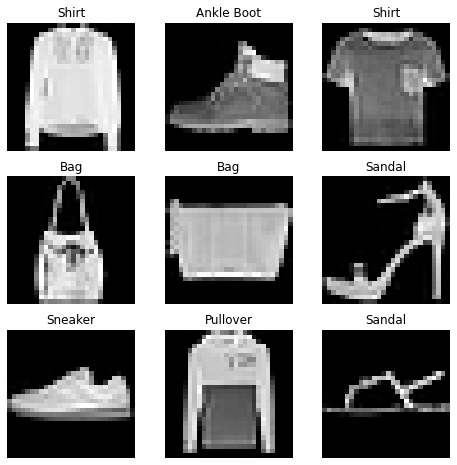

In [189]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Задание 1.
---
Выполнить обучение нейронной сети SimpleNet на изображениях FashionMNIST, настроив предварительно параметры нейросети. С учетом перекодировки целевой переменной у `target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device=torch.device("cuda")):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=0), dim=1)[1], torch.max(targets, dim=1)[1]).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch [{}] ——— Training Loss: {:.2f} ——— Validation Loss: {:.2f} ——— Accuracy: {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [5]:
model = SimpleNet()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SimpleNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(model, optimizer, torch.nn.CrossEntropyLoss(), train_loader, test_loader, epochs=4, device=device)

Epoch [0] ——— Training Loss: 0.61 ——— Validation Loss: 0.37 ——— Accuracy: 0.81


KeyboardInterrupt: 